In [3]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly.graph_objs as go

In [26]:
def v_2d_csv(filename,d):
    df = pd.read_csv(filename, header=None)
    data = df.values
    print(data.shape)
    tsne = TSNE(n_components=2, random_state=42)
    v_2d = tsne.fit_transform(data)
    print(v_2d.shape)
    df = pd.DataFrame(v_2d, columns=['x', 'y'])
    df.to_csv("v_2d_"+d+".csv", index=False)

In [20]:
def test_tsne_plot(filename,d):
    df = pd.read_csv(filename)
    data = df.values
    tsne = TSNE(n_components=2, random_state=42)
    v_2d = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    v_2d_gaza = np.concatenate((v_2d[:100], v_2d[400:500]))
    v_2d_election = np.concatenate((v_2d[100:200], v_2d[300:400]))
    v_2d_dispute = np.concatenate((v_2d[200:300], v_2d[500:600]))

    for index, (x, y) in enumerate(v_2d_gaza):
        plt.scatter(
            x, 
            y, 
            alpha=0.4, 
            color="blue",
            s=3, 
            label="Gaza" if index == 0 else "")

    for index, (x, y) in enumerate(v_2d_election):
        plt.scatter(
            x,
            y,
            alpha=0.4,
            color="green",
            s=3,
            label="India Election" if index == 0 else "",
        )

    for index, (x, y) in enumerate(v_2d_dispute):
        plt.scatter(
            x,
            y,
            alpha=0.4,
            color="red",
            s=3,
            label="South China Sea Dispute" if index == 0 else "",
        )
    plt.title(
        f"t-SNE visualization of document embeddings \n {d} dimensions"
    )

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.legend()
    plt.show()

In [103]:
def interactive_tsne_plot(filename, combined_summary, d):
    # Load the 2D embeddings and the summaries
    v_2d_df = pd.read_csv(filename)
    v_2d_df["language"] = ["English"] * 300 + ["Hindi"] * 100 + ["Chinese"] * 200
    # Example summary data (you should use the actual combined_summary data)
    v_2d_df["summary"] = [item["summary"].strip() for item in combined_summary]
    v_2d_df["topic"] = ["Gaza"] * 100 + ["India Election"] * 100 + ["South China Sea Dispute"] * 100 + ["India Election"] * 100 + ["Gaza"] * 100 + ["South China Sea Dispute"] * 100

    # Function to format summaries for hover text
    def format_summary(text: str) -> str:
        return text.replace("\n", "<br />")
    v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)

    # Create a color mapping for topics
    color_map = {
        "Gaza": "blue",
        "India Election": "red",
        "South China Sea Dispute": "green",
    }
    v_2d_df["color"] = v_2d_df["topic"].map(color_map)

    # Create a symbol mapping for languages
    symbol_map = {
        "English": "circle",
        "Chinese": "x",
        "Hindi": "triangle-up",
    }
    v_2d_df["symbol"] = v_2d_df["language"].map(symbol_map)

    # Create traces for each topic
    traces = []
    for topic in v_2d_df["topic"].unique():
        df = v_2d_df[v_2d_df["topic"] == topic]
        for language in df["language"].unique():
            df_language = df[df["language"] == language]
            trace = go.Scatter(
                x=df_language["x"],
                y=df_language["y"],
                mode="markers",
                name=f"{topic} ({language})",
                marker=dict(color=color_map[topic], symbol=symbol_map[language], size=8),
                customdata=df_language[["formatted_summary"]],
                hoverinfo="none",
            )
            traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f"t-SNE Visualization of News Articles with dimension {d}",
        xaxis=dict(title="t-SNE component 1"),
        yaxis=dict(title="t-SNE component 2"),
        showlegend=True,
    )

    # Create the figure
    fig = go.Figure(data=traces, layout=layout)

    # Save the plot as an HTML file with embedded JavaScript and CSS
    html_content = f"""
    <html>
    <head>
        <title>Interactive Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            #summary-box {{
                position: absolute;
                top: 10px;
                right: 10px;
                width: 400px;
                max-height: 600px;
                overflow-y: auto;
                background-color: white;
                border: 1px solid black;
                padding: 10px;
                z-index: 1000;
                white-space: pre-line;
            }}
        </style>
    </head>
    <body>
        <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
        <div id="summary-box">Hover over a point to see the summary here.</div>
        <script>
            document.addEventListener('DOMContentLoaded', function() {{
                const plotElement = document.querySelector('.plotly-graph-div');
                plotElement.on('plotly_hover', function(data) {{
                    if(data.points.length > 0) {{
                        const summary = data.points[0].customdata[0];
                        document.getElementById('summary-box').innerHTML = summary;
                    }}
                }});
                plotElement.on('plotly_unhover', function(data) {{
                    document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
                }});
            }});
        </script>
    </body>
    </html>
    """

    # Save the HTML content to a file
    with open("../data/plot/interactive_plot_" + d +".html", "w") as f:
        f.write(html_content)


In [37]:
def combine_summaries(filenames, output_filename):
    combined_summary = []
    for filename in filenames:
        with open(filename, "r") as f:
            combined_summary.extend(json.load(f))
    # Save the combined summaries to a new file
    with open(output_filename, "w") as f:
        json.dump(combined_summary, f, indent=4)
    print(f"Combined summaries saved to {output_filename}")
    return combined_summary

In [38]:
filenames = ['../data/QnA_data/QnA_summary_eng_Gaza_100.json',
 '../data/QnA_data/QnA_summary_eng_India_election_2024_100.json',
 '../data/QnA_data/QnA_summary_eng_Territorial_disputes_in_the_South_China_Sea_100.json',
 '../data/QnA_data/QnA_summary_hin_India_election_2024_100.json',
 '../data/QnA_data/QnA_summary_zho_Gaza_100.json',
 '../data/QnA_data/QnA_summary_zho_Territorial_disputes_in_the_South_China_Sea_100.json']

combine_summaries(filenames, "combined_summary.json")

Combined summaries saved to combined_summary.json


In [41]:
with open("combined_summary.json", "r") as f:
    combined_summary = json.load(f)

(600, 3)
(600, 2)


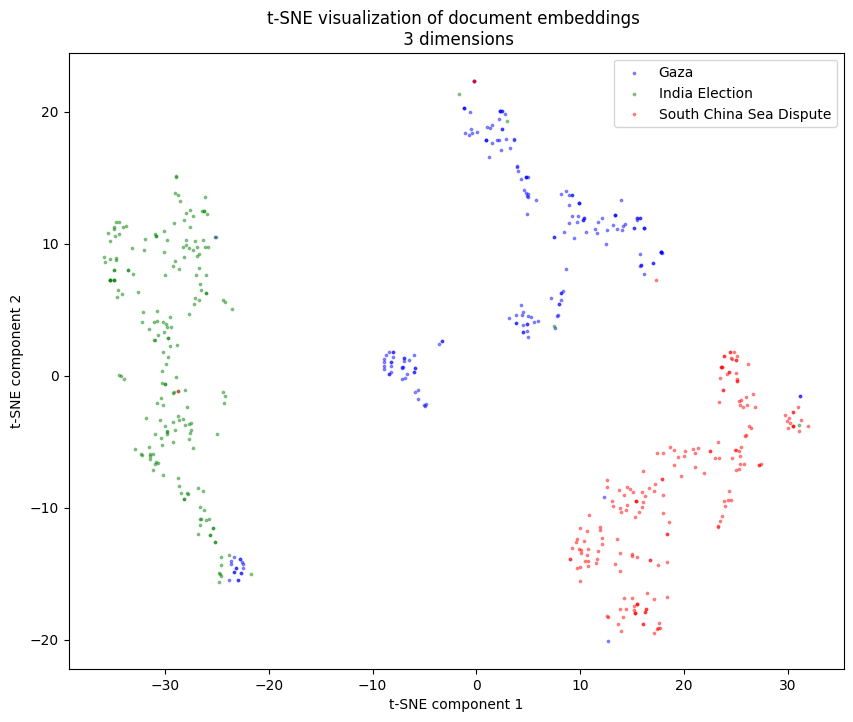

(600, 5)
(600, 2)


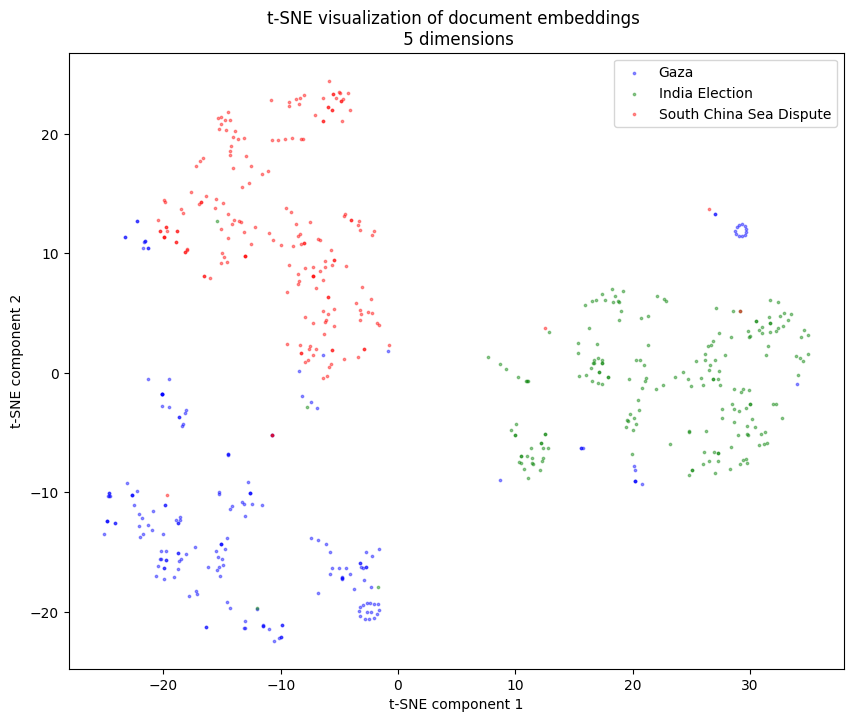

(600, 10)
(600, 2)


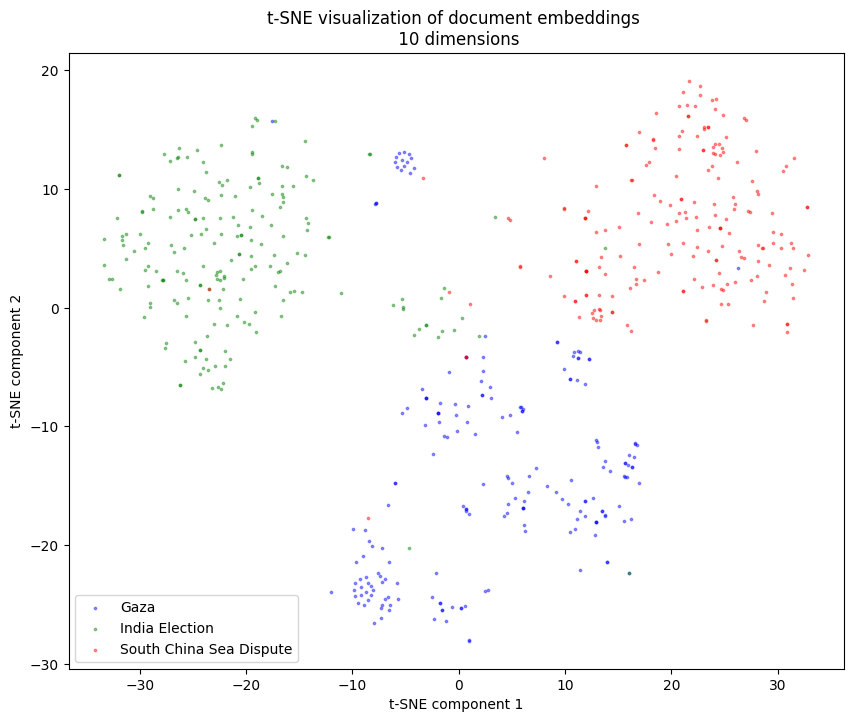

(600, 15)
(600, 2)


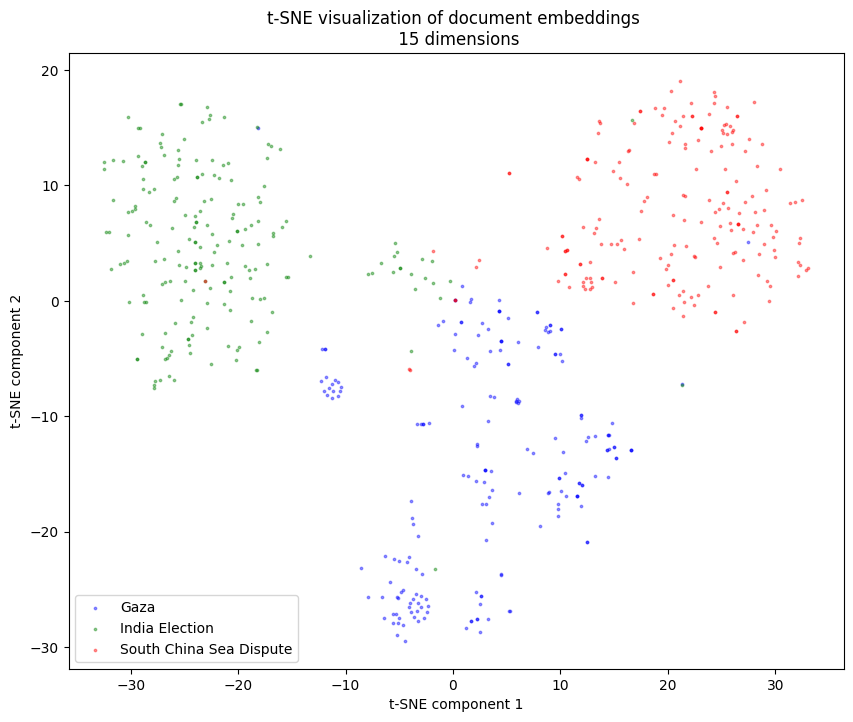

(600, 20)
(600, 2)


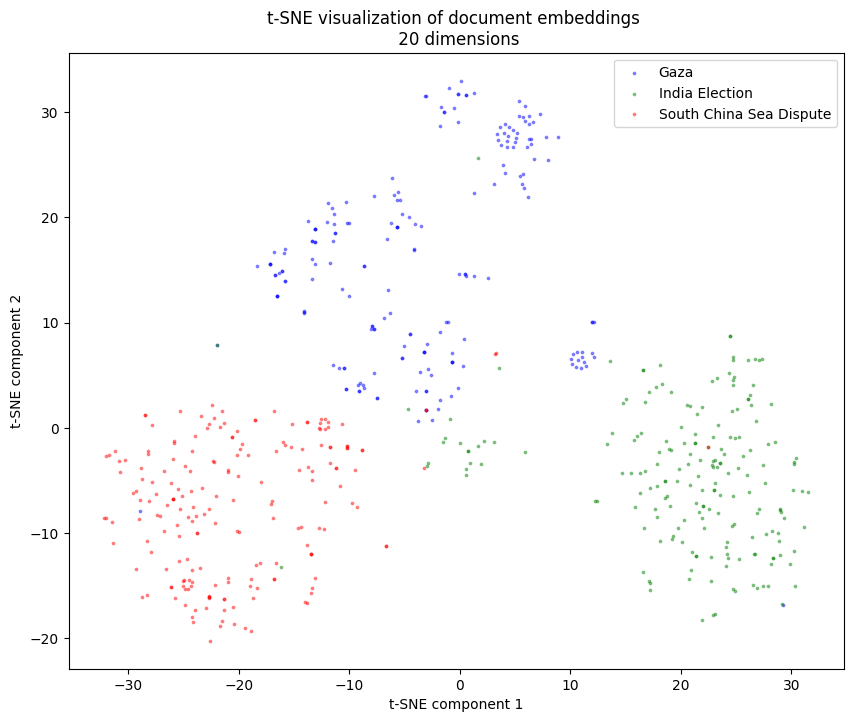

(600, 25)
(600, 2)


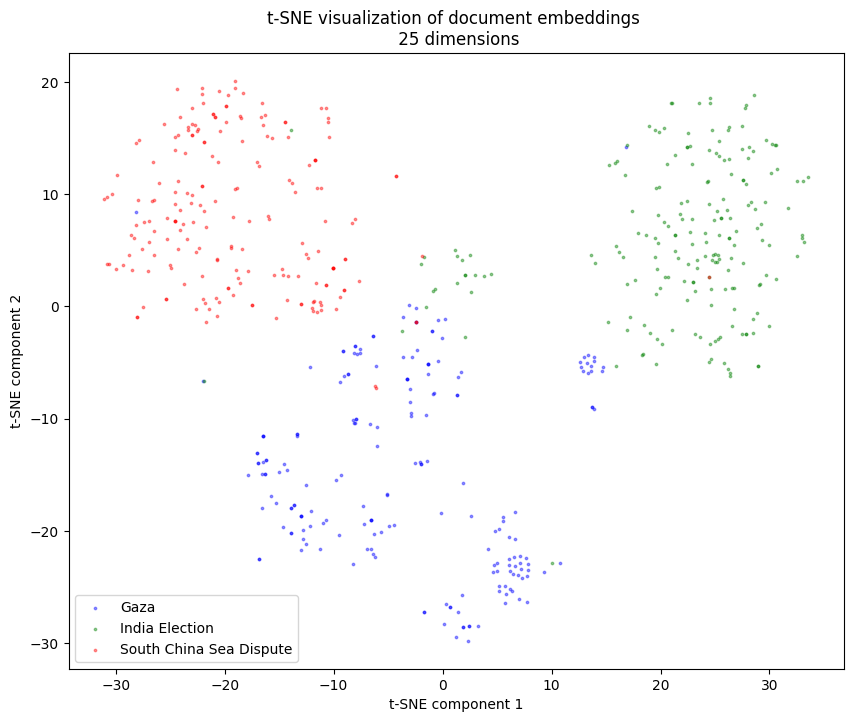

(600, 30)
(600, 2)


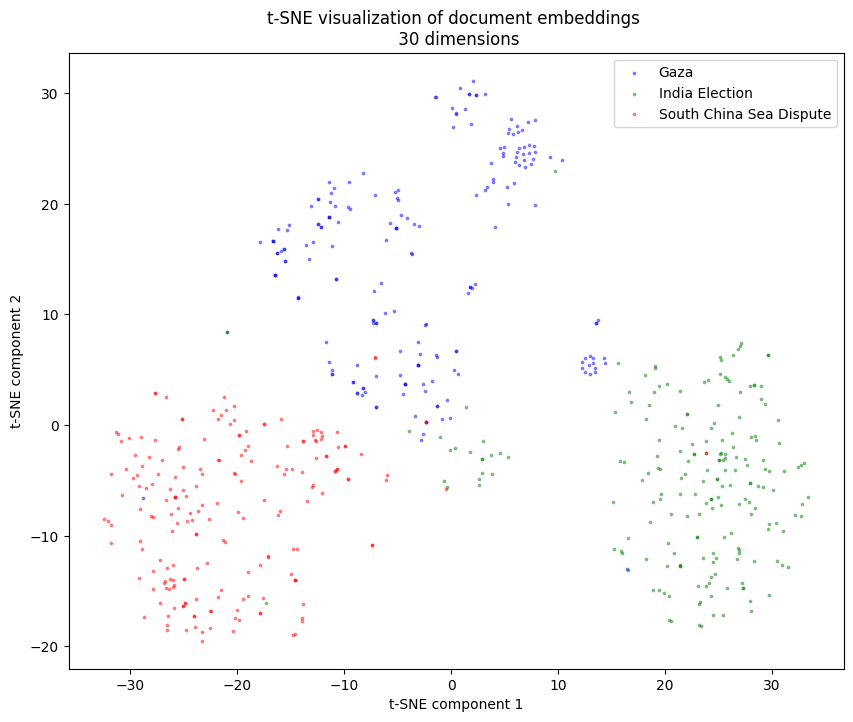

(600, 35)
(600, 2)


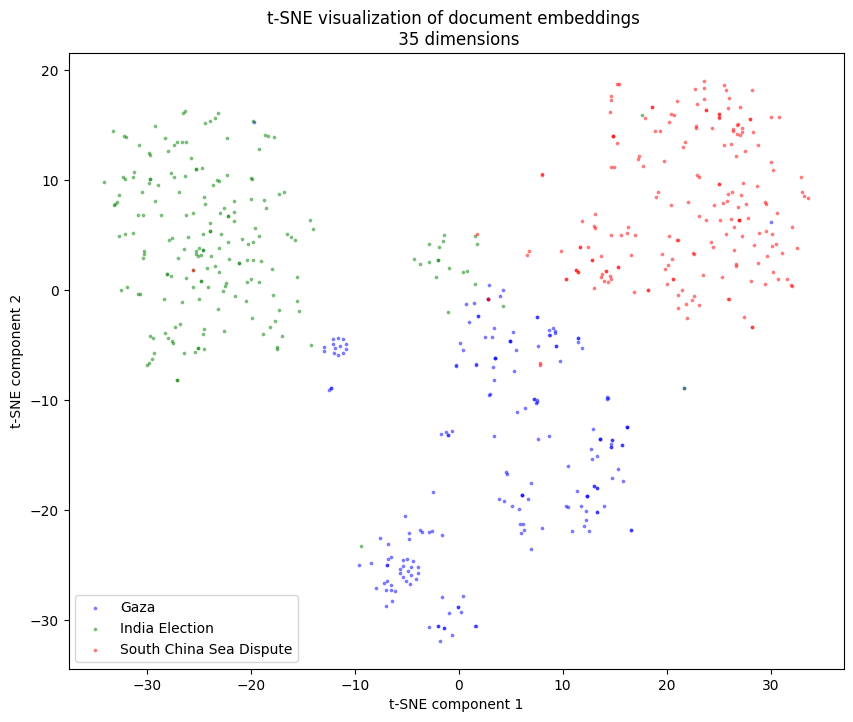

(600, 40)
(600, 2)


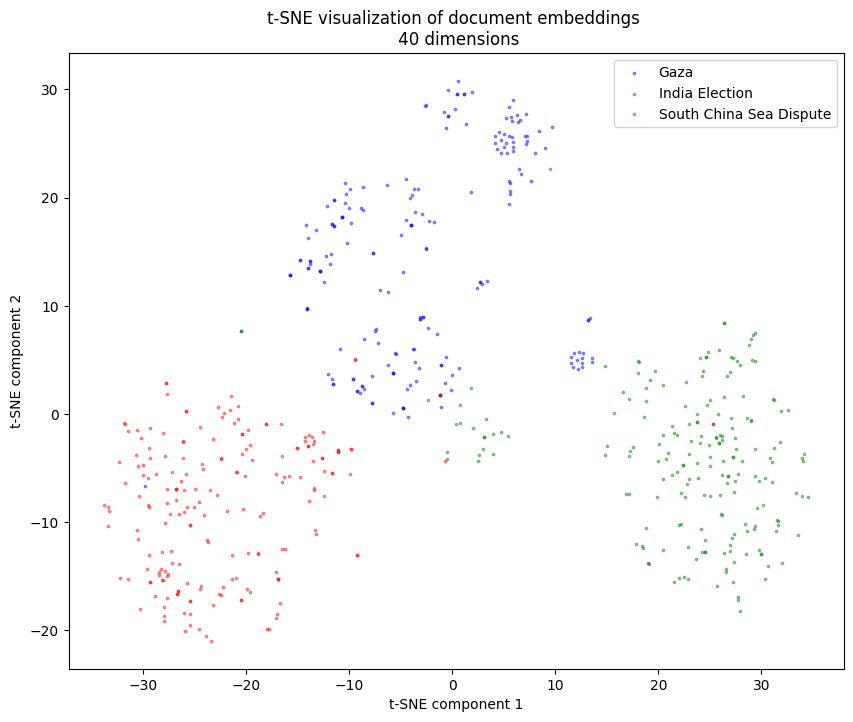

In [105]:
dimensions = ["3","5","10","15","20","25","30","35","40"]
for d in dimensions:
    v_2d_csv("../data/latent_vector/latent_vectors_" +d + ".csv",d)
    test_tsne_plot("../data/latent_vector/latent_vectors_" +d +".csv",d)
    interactive_tsne_plot("v_2d_" +d+ ".csv",combined_summary,d)

In [51]:
def bar_graph_by_topic(filename,d):
    df = pd.read_csv(filename)
    data = df.values
    plt.figure(figsize=(10, 8))
    gaza = np.concatenate((data[:100], data[400:500]))
    election = np.concatenate((data[100:200], data[300:400]))
    dispute = np.concatenate((data[200:300], data[500:600]))
    #take average of 3 colums for each topic
    average_gaza = gaza.mean(axis=0).tolist()
    average_election = election.mean(axis=0).tolist()
    average_dispute = dispute.mean(axis=0).tolist()
    
    #plot bar graph with x-axis as 3 columns and y-axis as average of 3 topics with different colors side by side
    x = [item for item in range(len(average_gaza))]
    barWidth = 0.25
    r1 = np.arange(len(x))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, average_gaza, color='blue', width=barWidth, edgecolor='grey', label='Gaza')
    plt.bar(r2, average_election, color='red', width=barWidth, edgecolor='grey', label='India Election')
    plt.bar(r3, average_dispute, color='green', width=barWidth, edgecolor='grey', label='South China Sea Dispute')
    plt.xlabel('Vectors', fontweight='bold')
    plt.ylabel('Average Embedding values', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(average_gaza))], x)
    plt.title(f"Bar graph of average of 3 topics with dimension {d}")
    plt.legend()
    plt.show()

    

In [52]:
def bar_graph_by_language(filename,d):
    df = pd.read_csv(filename)
    data = df.values
    print(data.shape)
    plt.figure(figsize=(10, 8))
    english = data[:300]
    hindi = data[300:400]
    chinease = data[400:600]
    
    #take average of 3 colums for each topic
    average_english = english.mean(axis=0).tolist()
    average_hindi = hindi.mean(axis=0).tolist()
    average_chinease = chinease.mean(axis=0).tolist()
    print(english.shape)

    x = [item for item in range(len(average_english))]
    barWidth = 0.25
    r1 = np.arange(len(x))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    plt.bar(r1, average_english, color='blue', width=barWidth, edgecolor='grey', label='English')
    plt.bar(r2, average_hindi, color='red', width=barWidth, edgecolor='grey', label='Hindi')
    plt.bar(r3, average_chinease, color='green', width=barWidth, edgecolor='grey', label='Chinese')
    plt.xlabel('Vectors', fontweight='bold')
    plt.ylabel('Average Embedding values', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(average_english))], x)
    plt.title(f"Bar graph of average of 3 languages with dimension {d}")
    plt.legend()
    plt.show()

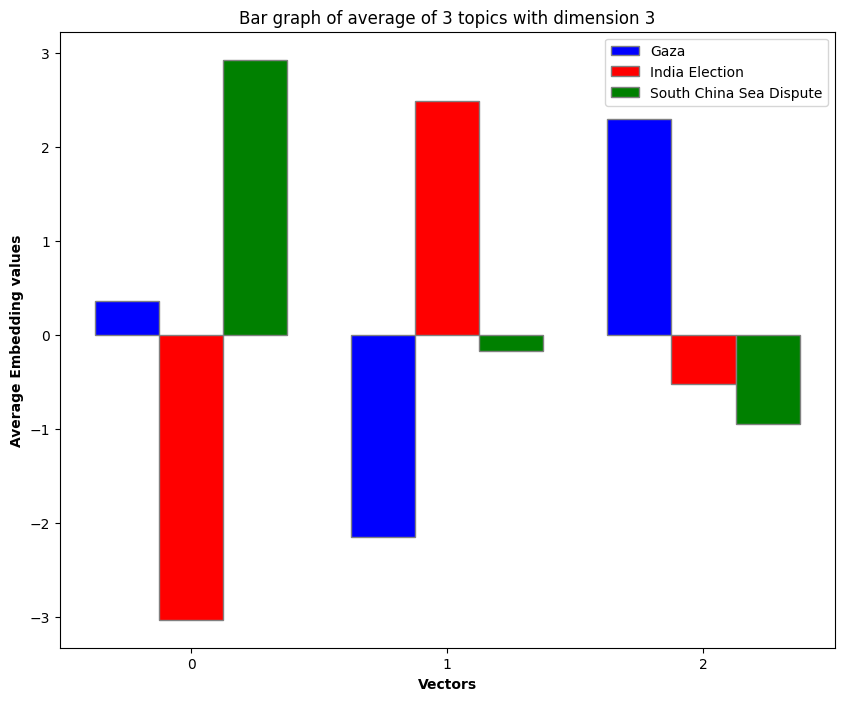

In [53]:
bar_graph_by_topic("../data/latent_vector/latent_vectors_3.csv",3)

Model Behavior Insights:
The embeddings indicate how the model differentiates between topics based on the information encoded in different vectors.

Dominance of Topics in Vectors:
Vector 0:

South China Sea Dispute is strongly positively associated, while India Election is strongly negatively associated.
Interpretation: This vector likely captures features or information that are positively related to the South China Sea Dispute but negatively related to India Elections. It could be indicative of geographical or political context differences.
Vector 1:

India Election has a strong positive association, while Gaza has a strong negative association.
Interpretation: This vector might capture sentiment or political dynamics that are positive in the context of India Elections but negative for Gaza. This could relate to the nature of the political coverage or public sentiment expressed in the articles.
Vector 2:

Gaza has a strong positive association, while India Election and South China Sea Dispute have negative associations.
Interpretation: This vector might be capturing aspects related to humanitarian or conflict-focused content, with Gaza-related articles having a distinct embedding compared to the other two topics.
Logical Explanation:
The distinct values across different vectors for each topic suggest that the model has learned to encode specific features or themes associated with each topic in different dimensions.

Topic Dominance:
Vector 0 is dominated by the South China Sea Dispute in a positive manner and by India Elections in a negative manner.
Vector 1 is dominated by India Elections positively and Gaza negatively.
Vector 2 is dominated by Gaza positively and the other two topics negatively.

(599, 3)
(300, 3)


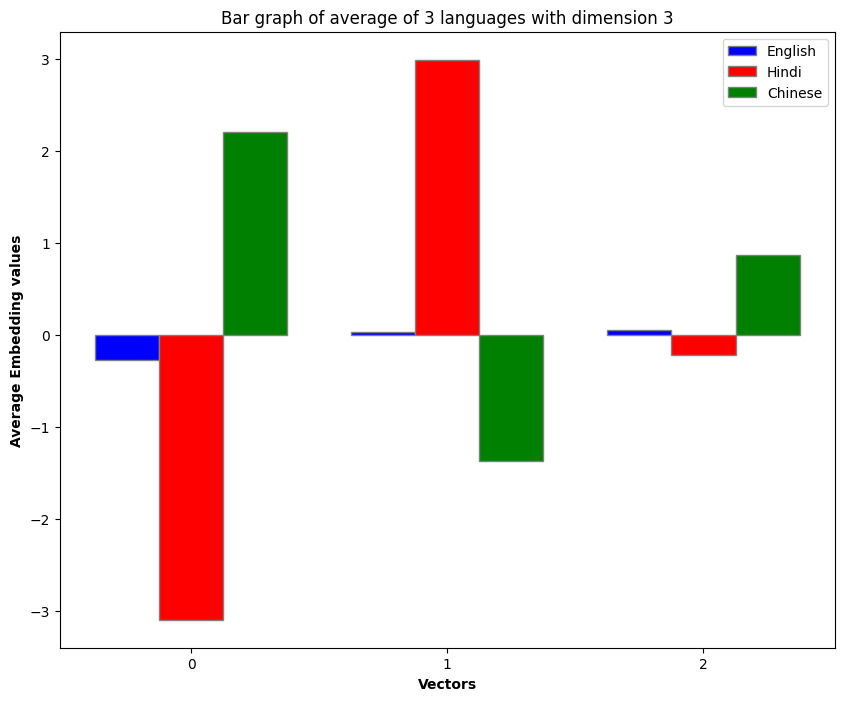

In [54]:
bar_graph_by_language("../data/latent_vector/latent_vectors_3.csv",3)

Model Behavior Insights:
The embeddings indicate how the model differentiates between languages based on the information encoded in different vectors.

Dominance of Languages in Vectors:
Vector 0:

Hindi shows a strong negative association, while Chinese has a strong positive association.
Interpretation: This vector captures features that are strongly negative for Hindi and strongly positive for Chinese. This might relate to specific linguistic or contextual features that are unique to Hindi and Chinese.
Vector 1:

Hindi shows a strong positive association, while Chinese has a strong negative association.
Interpretation: This vector captures features that are strongly positive for Hindi and negative for Chinese. This could relate to semantic or syntactic differences between these languages.
Vector 2:

Chinese shows a strong positive association, while Hindi has a slight negative association.
Interpretation: This vector captures features that are positive for Chinese and slightly negative for Hindi, possibly reflecting cultural or topical content differences.
Logical Explanation:
The distinct values across different vectors for each language suggest that the model has learned to encode specific features or themes associated with each language in different dimensions.

Language Dominance:
Vector 0 is dominated by Hindi negatively and Chinese positively.
Vector 1 is dominated by Hindi positively and Chinese negatively.
Vector 2 is dominated by Chinese positively and Hindi slightly negatively.
This behavior indicates that the model differentiates languages based on unique linguistic, contextual, or topical features. Such differentiation is essential for applications like multilingual understanding, translation, and language-specific sentiment analysis.

(599, 5)
(300, 5)


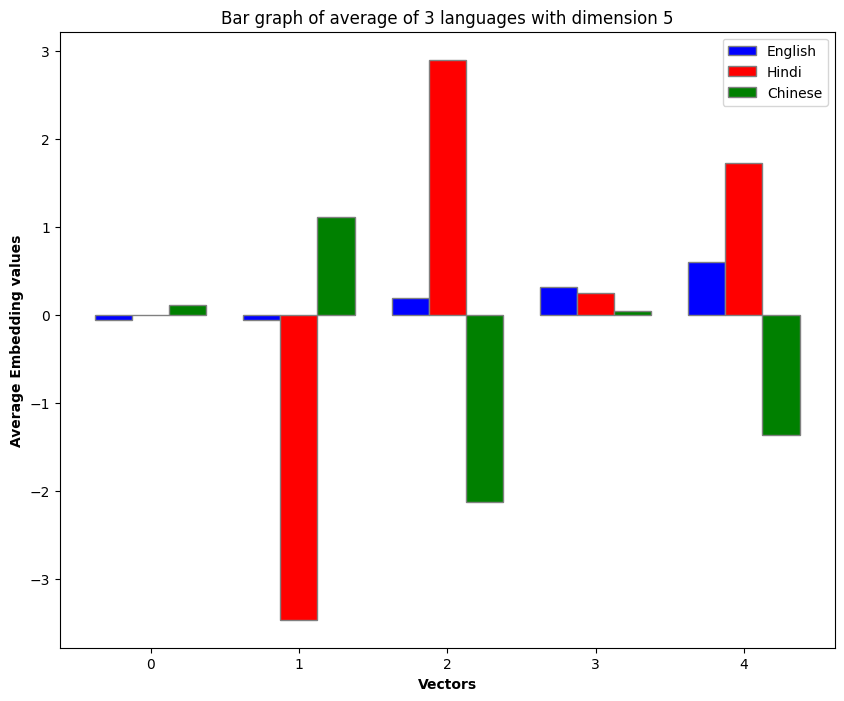

In [55]:
bar_graph_by_language("../data/latent_vector/latent_vectors_5.csv",5)

Model Behavior Insights:
The embeddings indicate how the model differentiates between languages based on the information encoded in different vectors.

Dominance of Languages in Vectors:
Vector 0:

All languages have values close to 0, indicating no strong differentiation in this vector.
Vector 1:

Hindi shows a strong negative association, while Chinese has a slight positive association.
Interpretation: This vector captures features that are strongly negative for Hindi and slightly positive for Chinese. This might relate to specific linguistic or contextual features of Hindi that are less prominent or absent in Chinese.
Vector 2:

Hindi shows a strong positive association, while Chinese has a strong negative association.
Interpretation: This vector captures features that are strongly positive for Hindi and negative for Chinese. It could relate to the syntactic or semantic differences between these languages.
Vector 3:

All languages have values close to 0, with slight positive values for English and Hindi.
Interpretation: This vector might capture more neutral or less distinctive features across the languages.
Vector 4:

Hindi shows a strong positive association, while Chinese has a strong negative association.
Interpretation: This vector captures features that are positive for Hindi and negative for Chinese, possibly relating to cultural or topical content that varies between these languages.
Logical Explanation:
The distinct values across different vectors for each language suggest that the model has learned to encode specific features or themes associated with each language in different dimensions.

Language Dominance:
Vector 1 is dominated by Hindi negatively.
Vector 2 is dominated by Hindi positively and Chinese negatively.
Vector 4 is dominated by Hindi positively and Chinese negatively.
This behavior indicates that the model differentiates languages based on unique linguistic, contextual, or topical features. Such differentiation is essential for applications like multilingual understanding, translation, and language-specific sentiment analysis.

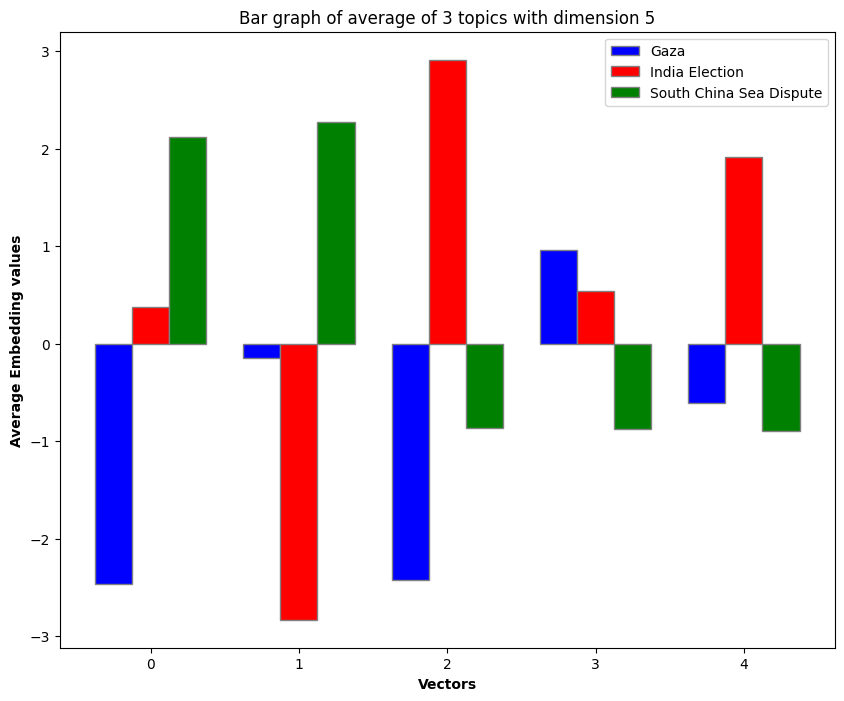

In [56]:
bar_graph_by_topic("../data/latent_vector/latent_vectors_5.csv",5)

Model Behavior Insights:
The embeddings indicate how the model differentiates between topics based on the information encoded in different vectors.

Dominance of Topics in Vectors:
Vector 0:

Gaza shows a strong negative association, while South China Sea Dispute has a strong positive association.
Interpretation: This vector captures features that are strongly negative for Gaza and strongly positive for the South China Sea Dispute. This might relate to specific conflict or geopolitical context that differentiates Gaza from the South China Sea Dispute.
Vector 1:

India Election shows a strong negative association, while South China Sea Dispute has a strong positive association.
Interpretation: This vector captures features that are strongly negative for India Election and strongly positive for the South China Sea Dispute. This could relate to political or geopolitical dynamics unique to these topics.
Vector 2:

India Election shows a strong positive association, while South China Sea Dispute has a moderately negative association.
Interpretation: This vector captures features that are strongly positive for India Election and negative for the South China Sea Dispute. This could reflect electoral or political content differences between these topics.
Vector 3:

Gaza shows a moderately positive association.
Interpretation: This vector captures features that are positive for Gaza, possibly reflecting humanitarian or conflict-focused content.
Vector 4:

India Election shows a strong positive association, while South China Sea Dispute has a moderately negative association.
Interpretation: This vector captures features that are positive for India Election and negative for the South China Sea Dispute, possibly reflecting political or conflict-related content differences.
Logical Explanation:
The distinct values across different vectors for each topic suggest that the model has learned to encode specific features or themes associated with each topic in different dimensions.

Topic Dominance:
Vector 0 is dominated by the South China Sea Dispute positively and Gaza negatively.
Vector 1 is dominated by the South China Sea Dispute positively and India Election negatively.
Vector 2 is dominated by India Election positively and South China Sea Dispute negatively.
Vector 3 shows positive association for Gaza.
Vector 4 is dominated by India Election positively and South China Sea Dispute negatively.
This behavior indicates that the model differentiates topics based on unique contextual or thematic information. Such differentiation is essential for applications like topic classification, where understanding the underlying context of the embeddings can lead to better performance and more accurate categorizations.

### Overall Interpretation:

Topic-wise Dominance:

Vector 0:
For both d=3 and d=5, the South China Sea Dispute is strongly positive, and Gaza is strongly negative in d=5.
Vector 1:
India Election is strongly positive in d=3 and strongly negative in d=5, while the South China Sea Dispute remains positive in both.
Vector 2:
India Election is slightly negative in d=3 and strongly positive in d=5, while the South China Sea Dispute is negative in both dimensions.
Language-wise Dominance:

Vector 0:
Hindi is strongly negative in d=3, and Chinese is positive in both dimensions.
Vector 1:
Hindi is strongly positive in d=3 and strongly negative in d=5, while Chinese remains negative in both dimensions.
Vector 2:
Hindi is slightly negative in d=3 and strongly positive in d=5, while Chinese is strongly positive in d=3 and strongly negative in d=5.

### Impact of Increasing Dimensions:
The overall pattern of dominance for specific topics and languages remains relatively consistent across the increase in dimensions from d=3 to d=5. Certain vectors consistently capture specific aspects of topics and languages.
The increase in dimensions introduces additional vectors, but the strong associations observed in d=3 continue to be reflected in d=5, suggesting that the additional dimensions capture more nuanced or additional features without drastically altering the dominance of the original vectors.

### Conclusion:
The model exhibits consistent embedding behaviors for both topics and languages, with certain vectors capturing specific aspects dominantly.
Increasing the dimensions from 3 to 5 introduces more detailed embeddings but does not significantly change the dominance patterns observed in the lower dimension.
This stability in dominance suggests that the model's ability to encode and differentiate features is robust across different dimensional settings, making it reliable for various NLP tasks.

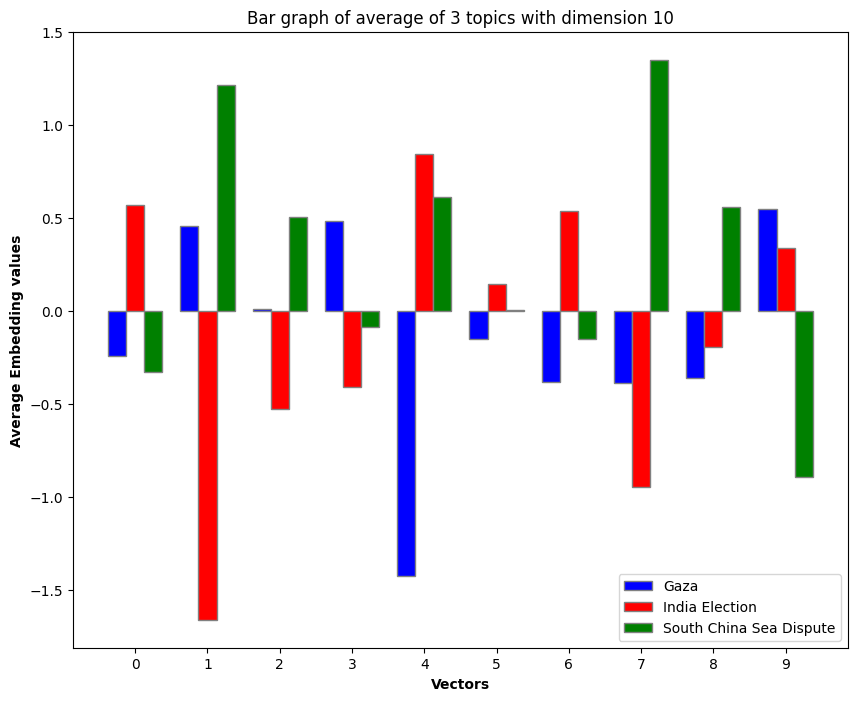

(599, 10)
(300, 10)


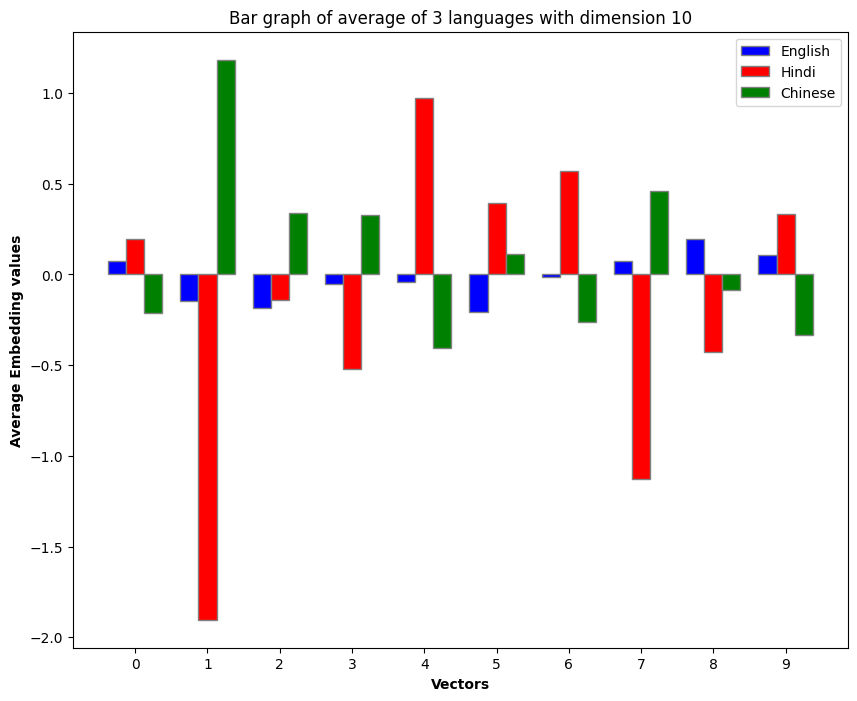

In [57]:
bar_graph_by_topic("../data/latent_vector/latent_vectors_10.csv",10)
bar_graph_by_language("../data/latent_vector/latent_vectors_10.csv",10)